In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, mean_squared_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet

## Load Data


In [2]:
# load and prep data
with open('./data/training set.pkl', 'rb') as fp:
    
    train_data = pickle.load(fp)
 
train_data.reset_index(drop = True, inplace = True)
train_data.dropna(inplace = True)

y =  train_data['lnpercapitaconsumption']
X = train_data.drop(columns = ['lnpercapitaconsumption'])
# scale 


# split data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.50, random_state=42)
poly = PolynomialFeatures(degree = 2, interaction_only=True)
X_train_2 = poly.fit_transform(X_train)
X_test_2 = poly.fit_transform(X_test)

In [3]:
raw = pd.read_csv('./data/peru_for_ml_course.csv')

rr = raw.loc[raw['lnpercapitaconsumption'].ge(0),:].reset_index(drop = True).dropna()

per_hh_head = rr.loc[y_test.index, 'h_hhsize']

In [4]:
# train all the models
with open('./models/lassobest.pkl', 'rb') as fp:
    lasso = pickle.load(fp)
    
with open('./models/ridgebest.pkl', 'rb') as fp:
    ridge = pickle.load(fp)
    
with open('./models/elbest.pkl', 'rb') as fp:
    elastic = pickle.load(fp)

C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Ridge from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator ElasticNet from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. U

In [5]:
lasso_pred = lasso.predict(X_test_2)
lasso_pred_exp = np.exp(lasso_pred)
ridge_pred = ridge.predict(X_test_2)
ridge_pred_exp = np.exp(ridge_pred)
el_pred = elastic.predict(X_test_2)
el_pred_exp =np.exp(el_pred)

predictions = [ridge_pred_exp,lasso_pred_exp, el_pred_exp]
model_names = ['Ridge', 'Lasso', 'Elastic-Net']

In [6]:
national_num_households = 6750000
program_monthly = (880*1e6)/12


def utility(y_pred,level, rho, benefits =program_monthly):

    # pick out poor people
    is_poor = y_pred < level
    num_poor = np.sum(is_poor)
    pct_is_poor = num_poor/y_pred.shape[0]
    #pct_households_incl = 
    national_hh_incl = national_num_households * pct_is_poor
    per_hh_benefits = benefits/national_hh_incl
    # decide how much each poor gets
    gets_benefits = is_poor * per_hh_benefits
    # give the poor money
    add_benefits = y_pred + gets_benefits 
    #utility calculations
    per_capita_benefits = add_benefits/per_hh_head
    numerator = np.power(per_capita_benefits, 1 - rho)
    
    results = np.sum(numerator)/(1 - rho)
    
    return results#, per_capita_benefits, add_benefits, gets_benefits, pct_is_poor, national_hh_incl


In [7]:
# make the utility graph
cutoff = np.arange(1,101,1)

crra_dict = {}

for model,pred in zip(model_names,predictions):
    
    temp_utility = np.zeros(len(cutoff))
    
    for j in cutoff:
    
        temp_utility[j-1] = utility(pred, np.percentile(pred,j), rho = 3)
    
    crra_dict[model] = temp_utility


0.14
0.14
0.15


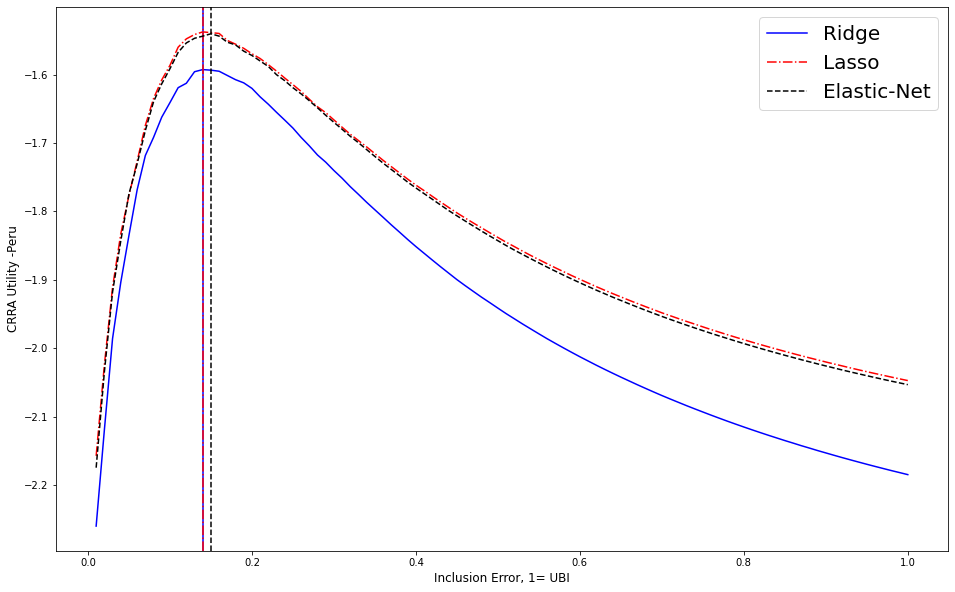

In [9]:
plt.figure(1,figsize=(16,10))
style = ['-','-.','--']
color = ['b','r', 'k']
incl_err = cutoff/100

for utility, color,style in zip(crra_dict.values(),color,style):
    
    plt.plot(incl_err, utility, color = color, linestyle = style)

    plt.axvline(incl_err[utility.argmax()], color = color, linestyle = style, label='_nolegend_')
    print(incl_err[utility.argmax()])
    
plt.legend(model_names,prop={'size': 20})
plt.ylabel('CRRA Utility -Peru', fontsize = 12)
plt.xlabel('Inclusion Error, 1= UBI', fontsize = 12)
plt.savefig('welfare_analysis_all_models.png')